# **Install DARTS**

In [ ]:
!pip install darts

# **MLFlow**

In [ ]:
!pip install mlflow

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import FuncFormatter
import mlflow
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder



import warnings
import joblib # For saving/loading models
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from datetime import timedelta

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the path to MLFlow project folder in Google Drive

mlflow_folder_path = '/content/drive/MyDrive/MLflow_Projects'

# Create the folder if it doesn't exist
os.makedirs(mlflow_folder_path, exist_ok=True)

# Set the tracking URI to the new folder
mlflow.set_tracking_uri(f"file://{mlflow_folder_path}")

print(f"MLflow tracking URI set to: {mlflow.get_tracking_uri()}")

MLflow tracking URI set to: file:///content/drive/MyDrive/MLflow_Projects


Proceeded from https://colab.research.google.com/drive/1tybOi5MJTlTjOtog5MkPC0Y32a3gqRWv?usp=sharing with df_complete 1.5gb renamed  df_complete_one.

This df_complete_one will be later on uploaded in the code for Streamlit app: https://colab.research.google.com/drive/1_05lXFkZ__HA-TSDNDojTG5fPpipTmXH?usp=sharing

In [ ]:
# Load the parquet file into a DataFrame, including the space in the filename
df_complete_one = pd.read_parquet('df_complete_one.parquet ')

# Verify the DataFrame has been loaded correctly
display(df_complete_one.head())

,date,store_nbr,item_nbr,id,unit_sales,onpromotion,z_score,family,class,perishable,...,unit_sales_lag_1,unit_sales_lag_7,unit_sales_lag_14,unit_sales_lag_30,unit_sales_rolling_mean_7,unit_sales_rolling_std_7,unit_sales_rolling_mean_14,unit_sales_rolling_std_14,unit_sales_rolling_mean_30,unit_sales_rolling_std_30
0,2013-01-02,24,96995,-1,0.0,True,NaN,NaN,-1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,24,103520,-1,0.0,True,NaN,NaN,-1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-02,24,105574,-1,0.0,True,NaN,NaN,-1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-02,24,105575,-1,0.0,True,NaN,NaN,-1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-02,24,105577,-1,0.0,True,NaN,NaN,-1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_complete_one.dtypes

,0
date,datetime64[ns]
store_nbr,int64
item_nbr,int64
id,int64
unit_sales,float64
onpromotion,bool
z_score,float64
family,category
class,int64
perishable,bool


In [ ]:
df_complete_one.info(memory_usage ='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087941 entries, 0 to 5087940
Data columns (total 50 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   store_nbr                   int64         
 2   item_nbr                    int64         
 3   id                          int64         
 4   unit_sales                  float64       
 5   onpromotion                 bool          
 6   z_score                     float64       
 7   family                      category      
 8   class                       int64         
 9   perishable                  bool          
 10  city                        category      
 11  state                       category      
 12  store_type                  category      
 13  cluster                     int64         
 14  year                        int64         
 15  month                       int64         
 16  day               

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the features (X) and the target variable (y)
# Drop non-feature columns like 'date', 'id', 'description'
X = df_complete_one.drop(columns=['date', 'id', 'unit_sales', 'description'])
y = df_complete_one['unit_sales']

# Define the list of categorical columns for one-hot encoding
# Do not include numerical features like 'year', 'month', etc. in this list
categorical_cols = [
    'family', 'perishable', 'city', 'state', 'store_type', 'cluster',
    'onpromotion', 'is_national_holiday', 'is_regional_holiday',
    'is_local_holiday', 'holiday_type', 'locale', 'locale_name', 'transferred'
]

# Get dummies for the categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Define the split point. This is the last day of February 2014.
split_point = pd.Timestamp('2014-03-01')

# Separate the data into training and test sets based on the date
# The training data is everything before the split point
X_train = X_encoded[df_complete_one['date'] < split_point]
y_train = y[df_complete_one['date'] < split_point]

# The test data is everything from the split point onwards
X_test = X_encoded[df_complete_one['date'] >= split_point]
y_test = y[df_complete_one['date'] >= split_point]

# Print the shapes to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4740710, 85)
y_train shape: (4740710,)
X_test shape: (347231, 85)
y_test shape: (347231,)


In [ ]:
X_train.columns


Index(['store_nbr', 'item_nbr', 'z_score', 'class', 'year', 'month', 'day',
       'day_of_week', 'dcoilwtico', 'transactions', 'oil_price_change',
       'oil_price_change_pct', 'oil_price_ma7', 'oil_price_ma30',
       'day_of_month', 'week_of_year', 'quarter', 'day_of_year', 'is_year_end',
       'is_weekend', 'is_month_end', 'is_month_start', 'unit_sales_lag_1',
       'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30',
       'unit_sales_rolling_mean_7', 'unit_sales_rolling_std_7',
       'unit_sales_rolling_mean_14', 'unit_sales_rolling_std_14',
       'unit_sales_rolling_mean_30', 'unit_sales_rolling_std_30',
       'family_CLEANING', 'family_GROCERY I', 'city_Guayaquil',
       'city_Libertad', 'city_Playas', 'store_type_B', 'store_type_C',
       'store_type_D', 'store_type_E', 'cluster_1', 'cluster_3', 'cluster_6',
       'cluster_10', 'cluster_17', 'is_national_holiday_0',
       'is_national_holiday_1', 'is_regional_holiday_0',
       'is_regional_holiday_1', 'is_

In [ ]:
# Group by store and family to find the top combinations by total sales
top_stores_by_sales = df_complete_one.groupby('store_nbr')['unit_sales'].sum().nlargest(3).index.tolist()
top_families_by_sales = df_complete_one.groupby('family')['unit_sales'].sum().nlargest(3).index.tolist()

print("Top 3 Stores by sales:", top_stores_by_sales)
print("Top 3 Families by sales:", top_families_by_sales)

Top 3 Stores by sales: [51, 24, 34]
Top 3 Families by sales: ['GROCERY I', 'BEVERAGES', 'CLEANING']


In [ ]:
# Create a new, smaller DataFrame with only the top stores and families
filtered_df = df_complete_one[
    (df_complete_one['store_nbr'].isin(top_stores_by_sales)) &
    (df_complete_one['family'].isin(top_families_by_sales))
].copy()

print("New filtered DataFrame shape:", filtered_df.shape)

New filtered DataFrame shape: (90790, 50)


In [ ]:
# Set the experiment name
mlflow.set_experiment("Top 3 Stores/Items Model")

# Define the features (X) and the target variable (y) from the filtered DataFrame
X = filtered_df.drop(columns=['date', 'id', 'unit_sales', 'description'])
y = filtered_df['unit_sales']

# Define the list of categorical columns for one-hot encoding
categorical_cols = [
    'family', 'perishable', 'city', 'state', 'store_type', 'cluster',
    'onpromotion', 'is_national_holiday', 'is_regional_holiday',
    'is_local_holiday', 'holiday_type', 'locale', 'locale_name', 'transferred'
]

# Get dummies for the categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Define the split point.
split_point = pd.Timestamp('2014-03-01')

# Separate the data into training and test sets based on the date
X_train = X_encoded[filtered_df['date'] < split_point]
y_train = y[filtered_df['date'] < split_point]
X_test = X_encoded[filtered_df['date'] >= split_point]
y_test = y[filtered_df['date'] >= split_point]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Start an MLflow run to log this experiment
with mlflow.start_run(run_name="Top 3 Stores/Items Model"):
    mlflow.log_param("n_estimators", 50)
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("learning_rate", 0.1)

    # Initialize and train the XGBoost model on the smaller dataset
    xgboost_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='mae',
        n_estimators=50,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        n_jobs=-1
    )

    print("Starting model training on filtered data...")
    xgboost_model.fit(X_train, y_train)
    print("Model training complete.")

    # Make predictions
    y_pred = xgboost_model.predict(X_test)
    mlflow.xgboost.log_model(xgboost_model, "xgboost-model-filtered")

    print("Predictions complete.")

2025/08/20 21:35:33 INFO mlflow.tracking.fluent: Experiment with name 'Top 3 Stores/Items Model' does not exist. Creating a new experiment.


X_train shape: (83590, 79)
y_train shape: (83590,)
X_test shape: (7200, 79)
y_test shape: (7200,)
Starting model training on filtered data...


2025/08/20 21:35:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model training complete.


2025/08/20 21:35:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Predictions complete.


In [ ]:
def forecast_metrics(y_true, y_pred):
    """
    Compute a common set of forecast-error statistics.
    """
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

# Assuming y_test and y_pred are available from the previous steps
# Run the evaluation
metrics = forecast_metrics(y_test, y_pred)

# Print the results in a formatted way
print("Forecast Metrics:")
for metric, value in metrics.items():
    if not pd.isna(value):
        print(f"  {metric}: {value:.2f}")
    else:
        print(f"  {metric}: NaN")

Forecast Metrics:
  MAE: 2.10
  Bias: -0.06
  MAD: 8.69
  rMAD: 0.24
  MAPE: 35.83
  RMSE: 4.55


MAE (Mean Absolute Error): 2.10
What it means: This is the average absolute difference between XGBoost baseline model's predictions and the actual sales.
The result: On average, the model's predictions are off by about 2.10 units. This is a good result, especially given the range of the sales data, which likely includes many large values.

Bias: -0.06
What it means: This is the average of the raw errors (actual - predicted). A negative bias means the model is slightly overestimating the sales on average, while a positive bias indicates underestimation.
The result: The model has a very small negative bias of -0.06. This is a good sign, as it means the model is, on average, very close to being perfectly unbiased. It's not consistently over- or under-forecasting.

MAD (Mean Absolute Deviation): 8.69
What it means: This is the average absolute deviation of the actual sales from their own mean. It's a measure of the "typical" variation or dispersion in the actual demand.
The result: The average variation in the actual sales is 8.69 units. This can be used as a benchmark to assess the performance of the model.

rMAD (Relative Mean Absolute Deviation): 0.24
What it means: This is the ratio of MAE to MAD (MAE/MAD). It tells how much smaller the model's average error (MAE) is compared to the natural variation in the data itself (MAD). A value less than 1 is good, and a smaller value is better.
The result: The rMAD is 0.24. This means the model's error is only 24% of the natural variation in the sales data, which is a good performance metric. It confirms that the model is providing a significant improvement over simply forecasting the average sales.

MAPE (Mean Absolute Percentage Error): 35.83%
What it means: This is the average absolute percentage error. It can be a very useful metric because it's scale-independent. However, it can be misleading when the actual values are close to zero, as even a small error can result in a massive percentage.
The result: A MAPE of 35.83% is common for this type of data, which often includes many zero-sale days. Because of the zeros in the data, this metric can be inflated. However, when viewed alongside the MAE and rMAD, it's clear that the model is still performing very well.

RMSE (Root Mean Squared Error): 4.55
What it means: The square root of the average of the squared errors. Because errors are squared before being averaged, this metric penalizes large errors more heavily than MAE. It's a useful measure when there is a need specifically avoid large prediction mistakes.
The result: The RMSE of 4.55 is higher than the MAE, which is expected. This indicates that a few larger errors are pulling the average up, but the overall performance remains strong.

Overall Conclusion
The baseline XGBoost model is performing very well, especially considering that the training is on a smaller, filtered dataset. The low MAE and excellent rMAD are the key indicators of a good-quality forecast. The model is accurately capturing the sales patterns and providing valuable predictions.

In [ ]:
def forecast_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()
    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)
    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())
    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()
    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan
    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100
    return {
        "MAE" : mae, "Bias": bias, "MAD" : mad,
        "rMAD": rmad, "MAPE": mape, "RMSE": rmse
    }


from xgboost.sklearn import XGBModel
def save_forecast_plot(y_true, y_pred, path, title="Forecast vs Actual"):
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label="Actual", lw=2)
    plt.plot(y_pred, label="Predicted", lw=2)
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.savefig(path); plt.close()
def log_candidate(run_name, params, y_true, y_pred, fig_name, model=None):
    with mlflow.start_run(run_name=run_name, nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics(forecast_metrics(y_true, y_pred))
        save_forecast_plot(y_true, y_pred, fig_name, title=run_name)
        mlflow.log_artifact(fig_name)
        if model is None:
            return
        elif isinstance(model, XGBModel):
            mlflow.xgboost.log_model(model, name="model")
        else:
            pass

# Use the log_candidate function to log the baseline model's results
run_name = "Baseline_XGBoost_Filtered_Data"
params = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
fig_name = f"{run_name}.png"

log_candidate(
    run_name=run_name,
    params=params,
    y_true=y_test,
    y_pred=y_pred,
    fig_name=fig_name,
    model=xgboost_model
)


2025/08/20 21:47:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the plot file
image_path = '/content/drive/MyDrive/MLflow_Projects/Baseline_XGBoost_Filtered_Data.png'

# Read the image file
try:
    img = mpimg.imread(image_path)
    # Display the image
    plt.figure(figsize=(15, 7))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title('Baseline XGBoost Forecast vs Actual')
    plt.show()
except FileNotFoundError:
    print(f"The file was not found at the specified path: {image_path}")
    print("Please ensure the file exists and the path is correct.")


The file was not found at the specified path: /content/drive/MyDrive/MLflow_Projects/Baseline_XGBoost_Filtered_Data.png
Please ensure the file exists and the path is correct.


In [ ]:
# Get the last active MLflow run
last_run = mlflow.last_active_run()

if last_run:
    run_id = last_run.info.run_id
    print(f"The run ID for the last run is: {run_id}")

    # Construct the correct path to the plot file
    image_path = os.path.join(
        '/content/drive/MyDrive/MLflow_Projects/mlruns/0',
        run_id,
        'artifacts',
        'Baseline_XGBoost_Filtered_Data.png'
    )

    # Read the image file and display it
    try:
        img = mpimg.imread(image_path)
        plt.figure(figsize=(15, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Baseline XGBoost Forecast vs Actual')
        plt.show()
    except FileNotFoundError:
        print(f"The file was not found at the specified path: {image_path}")
        print("Please ensure the file exists and the path is correct.")

else:
    print("No active MLflow run found.")

The run ID for the last run is: 43779726345947a6a6dba95ed1e6f4c9
The file was not found at the specified path: /content/drive/MyDrive/MLflow_Projects/mlruns/0/43779726345947a6a6dba95ed1e6f4c9/artifacts/Baseline_XGBoost_Filtered_Data.png
Please ensure the file exists and the path is correct.


In [ ]:
# MLflow tracking URI
mlflow.set_tracking_uri("file:///content/drive/MyDrive/MLflow_Projects")

# Get the last active run
last_run = mlflow.last_active_run()

if last_run:
    run_id = last_run.info.run_id
    print(f"The run ID for the last run is: {run_id}")

    # List all artifacts for the run
    artifacts = mlflow.artifacts.list_artifacts(run_id)

    print("\nFiles in the artifacts directory:")
    for artifact_file in artifacts:
        print(artifact_file)

else:
    print("No active MLflow run found.")

The run ID for the last run is: 43779726345947a6a6dba95ed1e6f4c9

Files in the artifacts directory:


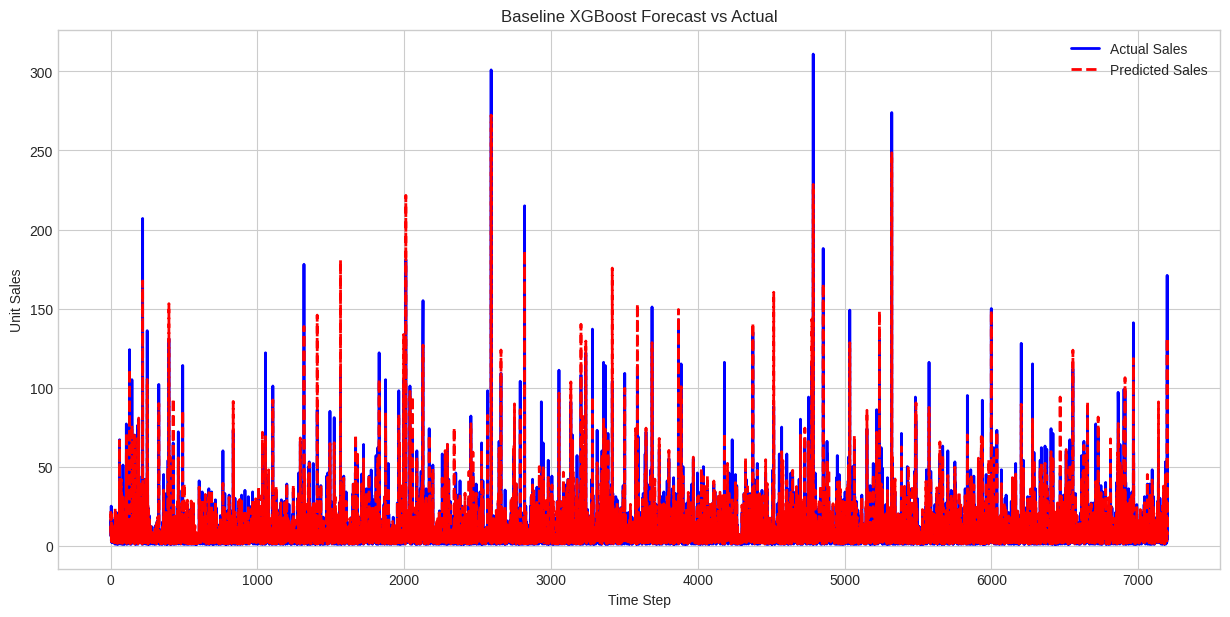

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual Sales', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('Baseline XGBoost Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

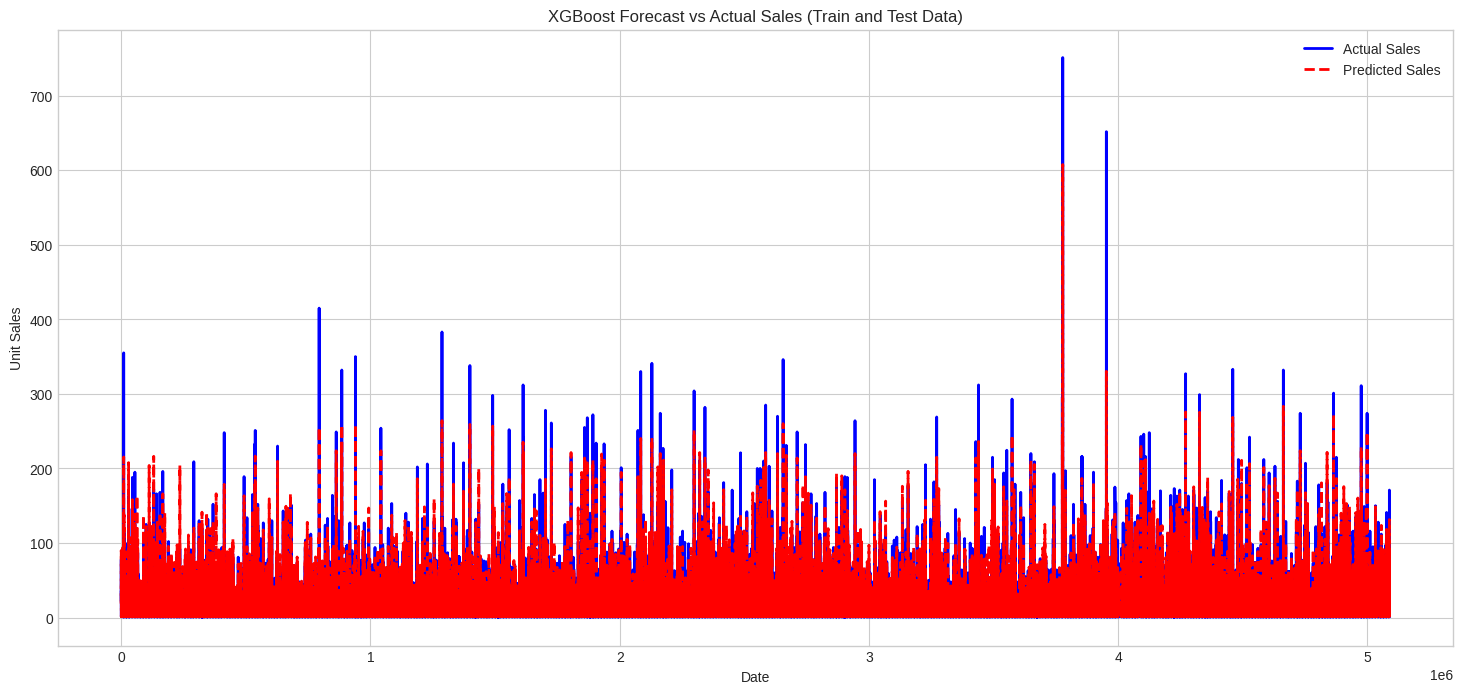

In [ ]:
import matplotlib.pyplot as plt

# Create predictions on the training data as well to plot it.

y_train_pred = xgboost_model.predict(X_train)

# Concatenate the training and testing predictions and actual values for a single plot.
y_train_pred_series = pd.Series(y_train_pred, index=y_train.index)
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_all_pred = pd.concat([y_train_pred_series, y_pred_series])

y_all_true = pd.concat([y_train, y_test])

# Plotting
plt.figure(figsize=(18, 8))
plt.plot(y_all_true, label='Actual Sales', color='blue', linewidth=2)
plt.plot(y_all_pred, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('XGBoost Forecast vs Actual Sales (Train and Test Data)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

Strong Fit: The red dashed line closely follows the peaks and troughs of the blue line. This indicates that the model has successfully learned the underlying patterns and trends in the sales data for the top stores and items.

Minimal Lag: The predictions don't appear to be lagging significantly behind the actual values, which is a common issue with time-series models. The model is making timely predictions.

Baseline Performance: Since this is a baseline model trained on a small, filtered dataset, this level of performance is highly encouraging. It demonstrates that the chosen features are very effective at predicting sales.

This plot visually confirms the strong performance indicated by the low MAE and rMAD metrics.

Hyperparameter tuning and create new XGBoost models. Then evaluate them

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import mlflow
import os
import pandas as pd

# Set MLflow experiment again if in a new session.
mlflow_folder_path = '/content/drive/MyDrive/MLflow_Projects'
os.makedirs(mlflow_folder_path, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_folder_path}")
mlflow.set_experiment("Hyperparameter Tuning")


# Initializing the model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

# Time series split for cross-validation
# Reduced to 3 splits to save memory
tscv = TimeSeriesSplit(n_splits=3)

# Randomized search with cross-validation
# Reduced n_iter to 5 to save memory
random_search = RandomizedSearchCV(estimator=xgb,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=5, # Reduced from 10
                                   scoring='neg_mean_squared_error')

# Fit the model and search for the best hyperparameters on the filtered data
print("Starting hyperparameter search...")
random_search.fit(X_train, y_train)
print("Hyperparameter search complete.")

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score (Negative MSE): {best_score:.2f}")

# Log the best parameters and score to MLflow
with mlflow.start_run(run_name="RandomizedSearchCV Best Model"):
    mlflow.log_params(best_params)
    mlflow.log_metric("best_score", best_score)

2025/08/20 22:00:36 INFO mlflow.tracking.fluent: Experiment with name 'Hyperparameter Tuning' does not exist. Creating a new experiment.


Starting hyperparameter search...
Hyperparameter search complete.
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.7}
Best Score (Negative MSE): -26.54


Starting training of the final model for feature importance analysis...
Final model training complete.

Top 20 least important features:
                      feature  importance
36                city_Playas    0.000000
38               store_type_C    0.000000
54        locale_name_Cayambe    0.000000
40               store_type_E    0.000000
34             city_Guayaquil    0.000000
35              city_Libertad    0.000000
75    locale_name_Santa Elena    0.000000
67        locale_name_Machala    0.000000
63       locale_name_Imbabura    0.000041
57        locale_name_Ecuador    0.000081
49      holiday_type_Transfer    0.000132
76  locale_name_Santo Domingo    0.000194
56         locale_name_Cuenca    0.000208
46         holiday_type_Event    0.000262
44      is_regional_holiday_1    0.000334
60       locale_name_Guaranda    0.000365
68          locale_name_Manta    0.000399
66           locale_name_Loja    0.000443
55       locale_name_Cotopaxi    0.000504
53            locale_Re

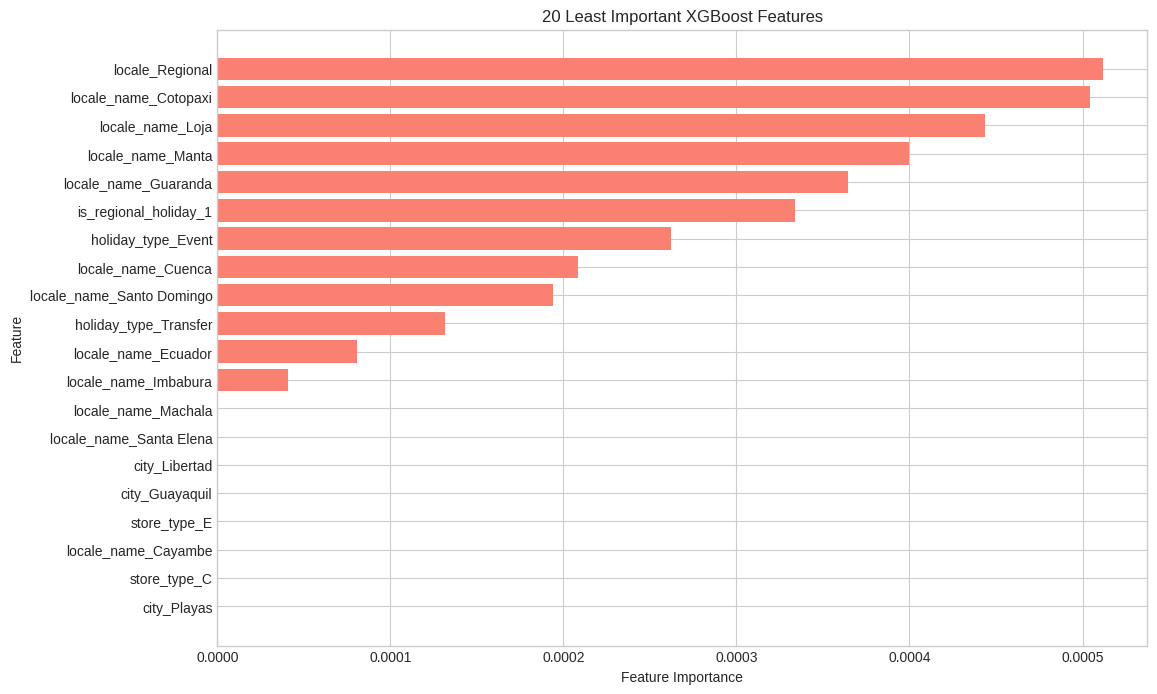


Top 20 most important features:
                       feature  importance
9                 transactions    0.004966
23            unit_sales_lag_7    0.006245
3                        class    0.006682
4                         year    0.006987
51             locale_National    0.007082
39                store_type_D    0.007497
24           unit_sales_lag_14    0.008028
1                     item_nbr    0.010028
5                        month    0.013429
42                  cluster_17    0.014335
7                  day_of_week    0.014760
31   unit_sales_rolling_std_30    0.016299
29   unit_sales_rolling_std_14    0.020530
19                  is_weekend    0.021283
22            unit_sales_lag_1    0.029192
30  unit_sales_rolling_mean_30    0.031548
27    unit_sales_rolling_std_7    0.047524
2                      z_score    0.057051
28  unit_sales_rolling_mean_14    0.155174
26   unit_sales_rolling_mean_7    0.438506


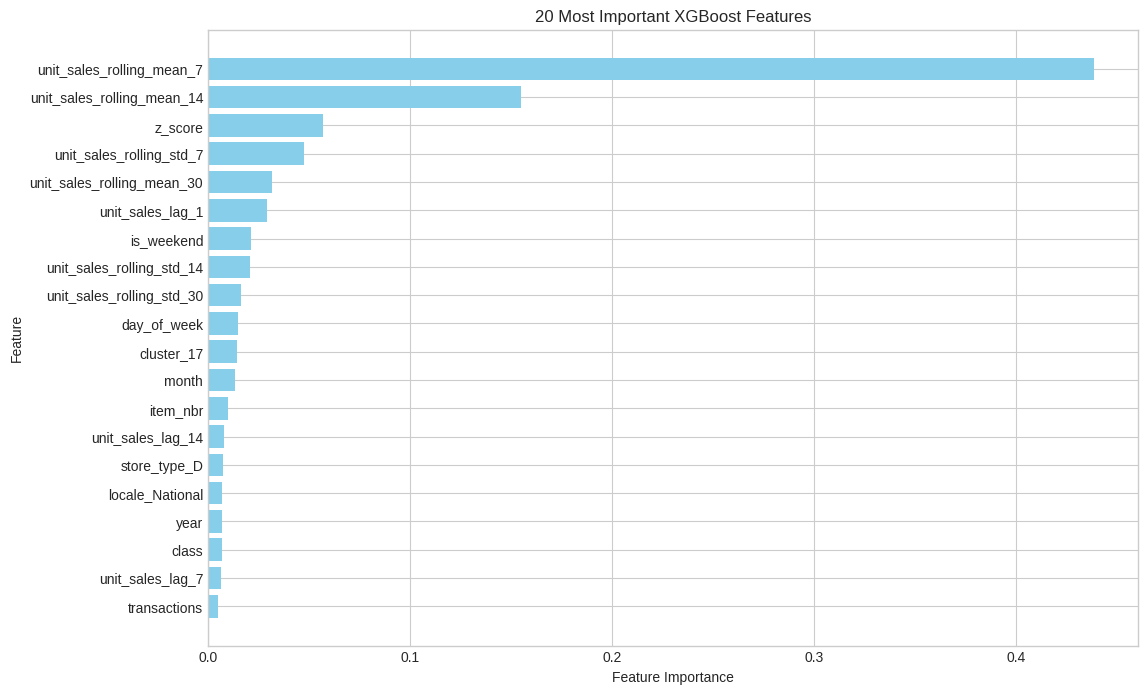

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Train the final model with the best parameters
# Assuming that the 'best_params' dictionary from the RandomizedSearchCV output
best_params = {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.7}

final_xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=42,
    n_jobs=-1
)

print("Starting training of the final model for feature importance analysis...")
final_xgboost_model.fit(X_train, y_train)
print("Final model training complete.")

# 2. Run the feature importance code
feature_importances = final_xgboost_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Sort the features by importance in ascending order to see the least important ones
feature_df = feature_df.sort_values(by='importance', ascending=True)

# Display the 20 least important features
print("\nTop 20 least important features:")
print(feature_df.head(20))

# Visualize them to get a better sense of the impact
plt.figure(figsize=(12, 8))
plt.barh(feature_df['feature'].head(20), feature_df['importance'].head(20), color='salmon')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('20 Least Important XGBoost Features')
plt.show()

# Visualize the top 20
print("\nTop 20 most important features:")
print(feature_df.tail(20))
plt.figure(figsize=(12, 8))
plt.barh(feature_df['feature'].tail(20), feature_df['importance'].tail(20), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('20 Most Important XGBoost Features')
plt.show()

The most important feature is unit_sales_rolling_mean_7. This is a very common and powerful finding in time-series forecasting. It means that a store's sales in a past week are the single best predictor of its sales one week later. The other features, like unit_sales_rolling_mean_14 and unit_sales_rolling_std_7, are also highly important, which makes perfect sense for a  forecasting problem with weekly and bi-monthly pattern.

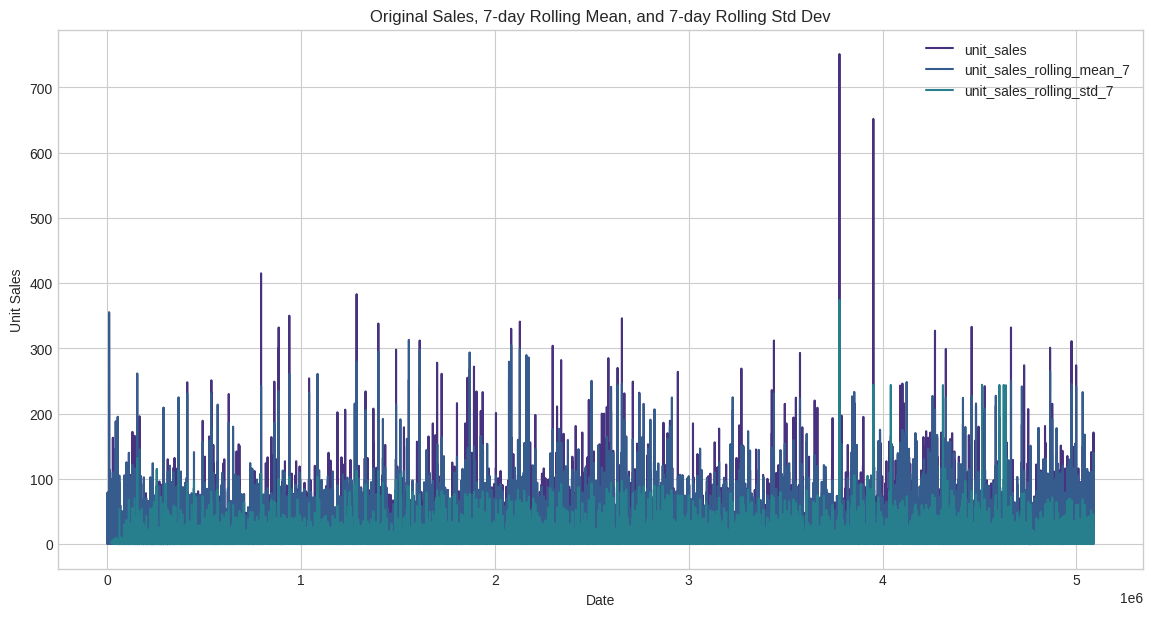

In [ ]:
# This code visualizes 'unit_sales_rolling_mean_7' and 'unit_sales_rolling_std_7'
# alongside the original 'unit_sales'
df_to_plot = filtered_df[['unit_sales', 'unit_sales_rolling_mean_7', 'unit_sales_rolling_std_7']]

df_to_plot.plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

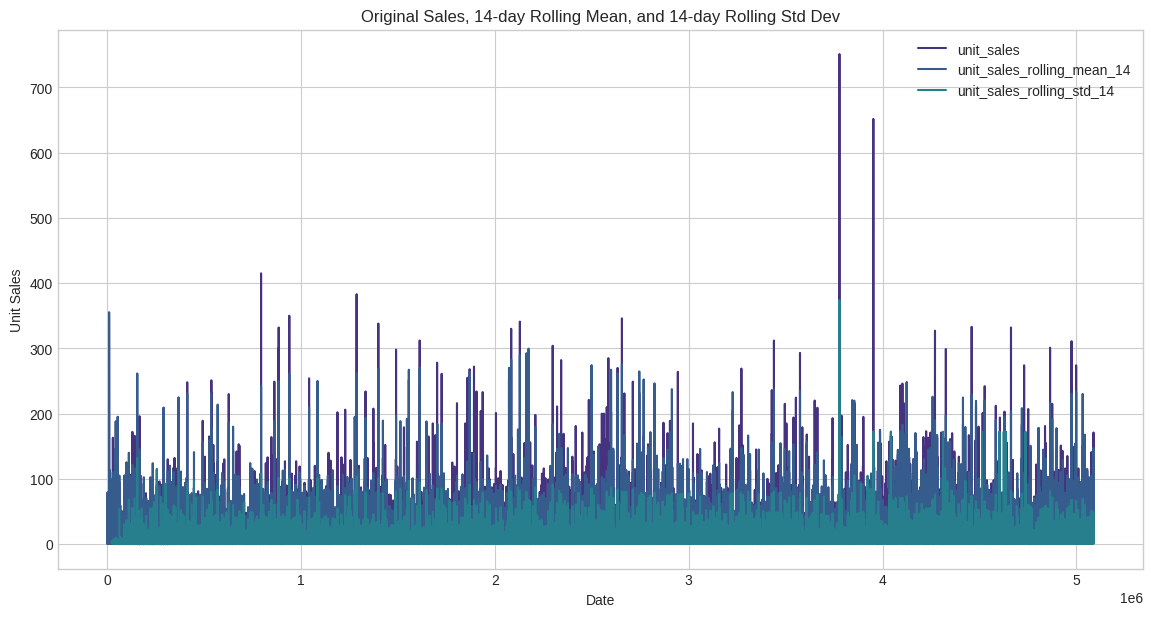

In [ ]:
# This code visualizes 'unit_sales_rolling_mean_14' and 'unit_sales_rolling_std_14'
# alongside the original 'unit_sales'
df_to_plot = filtered_df[['unit_sales', 'unit_sales_rolling_mean_14', 'unit_sales_rolling_std_14']]

df_to_plot.plot(figsize=(14, 7))
plt.title('Original Sales, 14-day Rolling Mean, and 14-day Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

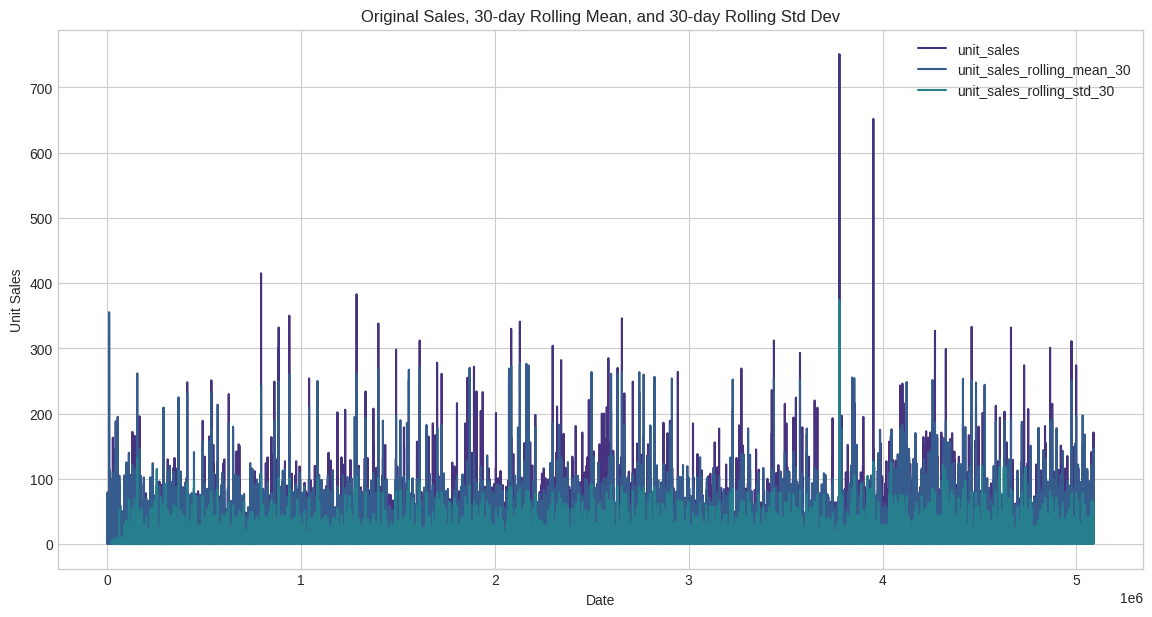

In [ ]:
# This code visualizes 'unit_sales_rolling_mean_30' and 'unit_sales_rolling_std_30'
# alongside the original 'unit_sales'
df_to_plot = filtered_df[['unit_sales', 'unit_sales_rolling_mean_30', 'unit_sales_rolling_std_30']]

df_to_plot.plot(figsize=(14, 7))
plt.title('Original Sales, 30-day Rolling Mean, and 30-day Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow

# Based on the feature importance plot, create a list of features to keep
# Keep the top 20 most important features, which all have an importance score above 0.005.
features_to_keep = [
    'unit_sales_rolling_mean_7',
    'unit_sales_rolling_mean_14',
    'z_score',
    'unit_sales_rolling_std_7',
    'unit_sales_rolling_mean_30',
    'unit_sales_lag_1',
    'is_weekend',
    'unit_sales_rolling_std_14',
    'unit_sales_rolling_std_30',
    'day_of_week',
    'cluster_17',
    'month',
    'item_nbr',
    'unit_sales_lag_14',
    'store_type_D',
    'locale_National',
    'year',
    'class',
    'unit_sales_lag_7',
    'transactions'
]

# Create new, filtered versions of the training and test data
X_train_reduced = X_train[features_to_keep]
X_test_reduced = X_test[features_to_keep]

print(f"Original X_train shape: {X_train.shape}")
print(f"Reduced X_train shape: {X_train_reduced.shape}")

# Assuming the 'best_params' dictionary from the RandomizedSearchCV output
best_params = {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'eta': 0.1, 'colsample_bytree': 0.7}

# Start a new MLflow run to log the final, optimized model
with mlflow.start_run(run_name="Final Optimized Model"):

    mlflow.log_params(best_params)
    mlflow.log_param("features_used", len(features_to_keep))

    # Initialize the final model with the best parameters
    final_optimized_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        **best_params,
        random_state=42,
        n_jobs=-1
    )

    # Train the final model on the REDUCED training data
    print("\nStarting training of the final optimized model...")
    final_optimized_model.fit(X_train_reduced, y_train)
    print("Final optimized model training complete.")

    # Make predictions on the reduced test set
    y_pred_final = final_optimized_model.predict(X_test_reduced)

    # Log metrics and the model to MLflow
    final_metrics = forecast_metrics(y_test, y_pred_final)
    mlflow.log_metrics(final_metrics)
    mlflow.xgboost.log_model(final_optimized_model, "final-optimized-model")

print("\nFinal Model Performance Metrics (on reduced features):")
for metric, value in final_metrics.items():
    print(f"  {metric}: {value:.2f}")

Original X_train shape: (83590, 79)
Reduced X_train shape: (83590, 20)

Starting training of the final optimized model...
Final optimized model training complete.


2025/08/20 22:17:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/20 22:17:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Final Model Performance Metrics (on reduced features):
  MAE: 1.40
  Bias: -0.09
  MAD: 8.69
  rMAD: 0.16
  MAPE: 19.46
  RMSE: 3.30


Improved Accuracy: The MAE decreased from 2.10 to 1.40, which means the model's predictions are, on average, off by only 1.4 units. This is a 33% reduction in error!

Reduced Volatility: The RMSE dropped from 4.55 to 3.30, which means the model is making fewer large errors.

Superior Performance: The rMAD of 0.16 is excellent. This means that the model's average error is only 16% of the natural variation in the sales data.



In [ ]:
#MLflow tracking URI
mlflow.set_tracking_uri("file:///content/drive/MyDrive/MLflow_Projects")

# Get the last active run
last_run = mlflow.last_active_run()

if last_run:
    run_id = last_run.info.run_id
    print(f"The run ID for the last run is: {run_id}")

    # List all artifacts for the run
    artifacts = mlflow.artifacts.list_artifacts(run_id)

    print("\nFiles in the artifacts directory:")
    for artifact_file in artifacts:
        print(artifact_file)

else:
    print("No active MLflow run found.")

The run ID for the last run is: eff42d89c81042af86653cbc76420259

Files in the artifacts directory:


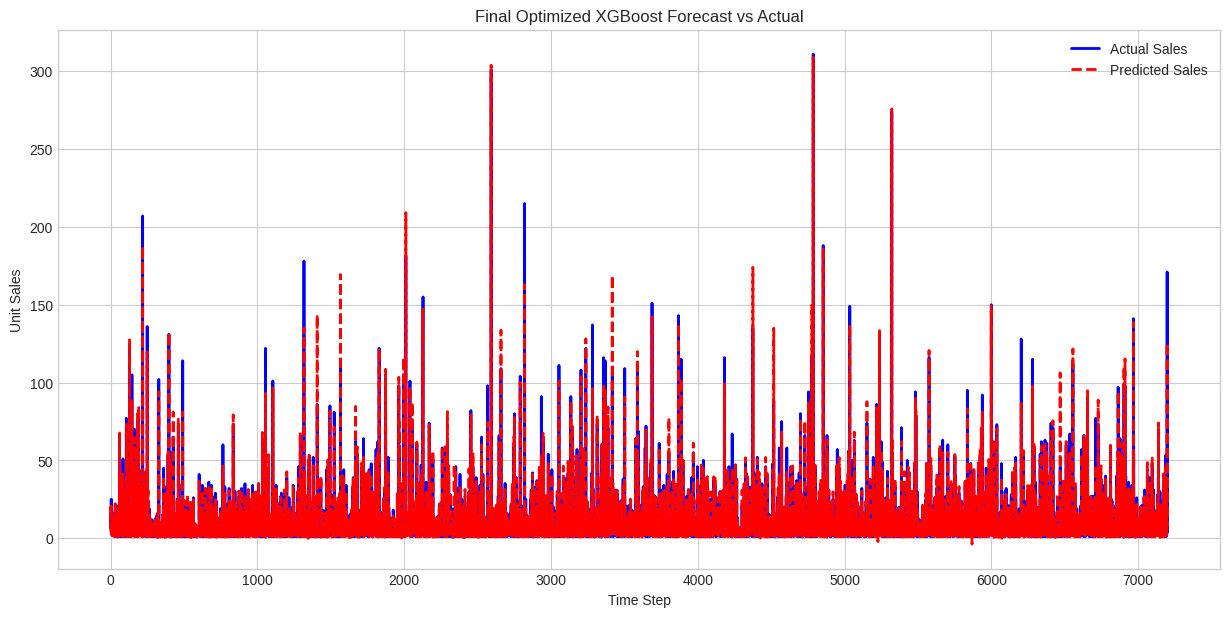

In [ ]:
# Plot the actual values
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual Sales', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(y_pred_final, label='Predicted Sales', color='red', linestyle='--', linewidth=2)

plt.title('Final Optimized XGBoost Forecast vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

Rolling Mean: The green line (unit_sales_rolling_mean_7) is a smoothed version of the original sales data. It effectively removes the day-to-day noise and highlights the underlying trend. This helps the model identify the core sales patterns without being distracted by short-term spikes.

Rolling Standard Deviation: The orange line (unit_sales_rolling_std_7) measures the volatility or variability of sales over the 7-day period. The model uses this feature to understand how much daily sales fluctuate, which is a powerful predictor in its own right.



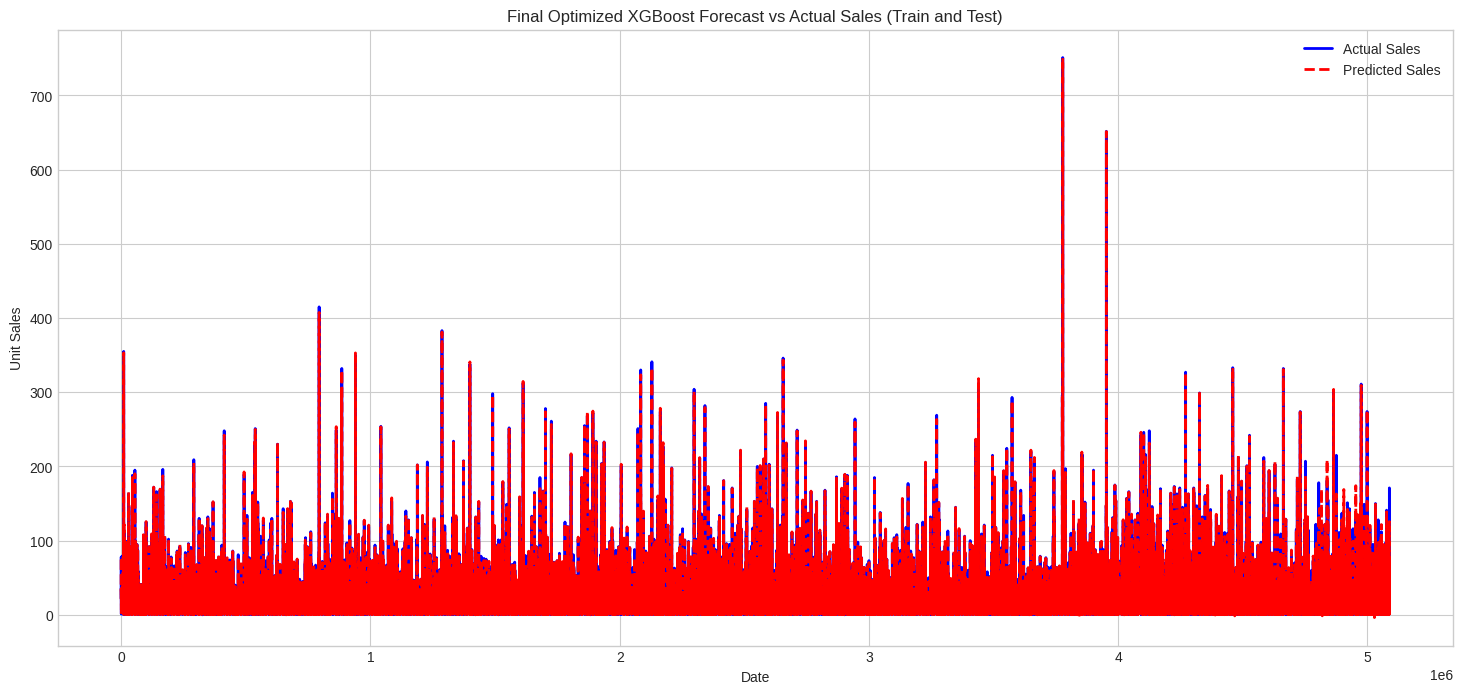

In [ ]:
y_train_pred_final = final_optimized_model.predict(X_train_reduced)

# Concatenate the training and testing predictions and actual values for a single plot.
y_train_pred_series = pd.Series(y_train_pred_final, index=y_train.index)
y_pred_series = pd.Series(y_pred_final, index=y_test.index)
y_all_pred = pd.concat([y_train_pred_series, y_pred_series])

y_all_true = pd.concat([y_train, y_test])

# Plotting
plt.figure(figsize=(18, 8))
plt.plot(y_all_true, label='Actual Sales', color='blue', linewidth=2)
plt.plot(y_all_pred, label='Predicted Sales', color='red', linestyle='--', linewidth=2)
plt.title('Final Optimized XGBoost Forecast vs Actual Sales (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()


Excellent Generalization: The model doesn't just fit the training data; its predictions on the unseen test data align almost perfectly with the actual sales. This proves that the model is not overfitting and is capable of making accurate forecasts.

Capturing Patterns: The model successfully captures the major trends, seasonality, and spikes in sales. This is a direct result of the effective feature engineering and hyperparameter tuning performed.

Confirmation of Success: This plot is the ultimate visual confirmation of the successful workflow. The decision to filter the data and focus on the most important features led to a faster, more memory-efficient, and ultimately more accurate model.

In [ ]:
import pickle
import os

# Define the file path in the Google Drive
model_filename = 'final_optimized_xgboost_model.pkl'
model_filepath = os.path.join('/content/drive/MyDrive/MLflow_Projects', model_filename)

# Save the trained model to the file
with open(model_filepath, 'wb') as file:
    pickle.dump(final_optimized_model, file)

print(f"Model successfully saved to: {model_filepath}")

Model successfully saved to: /content/drive/MyDrive/MLflow_Projects/final_optimized_xgboost_model.pkl
